<a href="https://colab.research.google.com/github/moreirarodrigo-eo/Markov_Chain_LU/blob/main/Markov_Chain_LU_mapbiomas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

In [ ]:
import pandas as pd
!pip install geopandas
import geopandas as gpd
!pip install geemap
import geemap

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.api.types import is_categorical_dtype
from pandas.api.types import infer_dtype
import numpy as np
!pip install giddy
import giddy

In [ ]:
ro = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME','Rondonia'))

randomPoints = ee.FeatureCollection.randomPoints(region = ro, points = 50000, seed = 42, maxError = 1);

In [ ]:
lu = ee.Image('projects/mapbiomas-workspace/public/collection7/mapbiomas_collection70_integration_v2').clip(ro)#.select(['classification_2019', 'classification_2020'])

extracted_values = lu.sample(region= randomPoints, scale= 30, geometries= True)
sample_result = extracted_values.first().getInfo()
column_df = list(sample_result['properties'].keys())
nested_list = extracted_values.reduceColumns(ee.Reducer.toList(len(column_df)), column_df).values().get(0)
data = nested_list.getInfo()
df = pd.DataFrame(data, columns = column_df)


In [ ]:
df = df.loc[(df!=0).all(axis=1)]

print(df.stack().unique())


[12  3 15 11 33  4 41 39 24 30 21 25  9]


In [ ]:
land_use_labels = {
                   25: 'Other non Vegetated Areas', 
                   21: 'mosaic of uses', 
                   15:'pasture',  
                   3:'forest', 
                   12:'grassland', 
                   39:'soybean', 
                   33:'water', 
                   11:'wetland', 
                   41:'temporary crops', 
                   30:'mining',  
                   4:'savanna', 
                   24:'urban',  
                   9:'forest plantation'}
land_use = df.replace(land_use_labels)
land_use = land_use.dropna()
land_use

,classification_1985,classification_1986,classification_1987,classification_1988,classification_1989,classification_1990,classification_1991,classification_1992,classification_1993,classification_1994,...,classification_2012,classification_2013,classification_2014,classification_2015,classification_2016,classification_2017,classification_2018,classification_2019,classification_2020,classification_2021
0,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,...,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland
1,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,...,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland
2,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,...,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland
3,forest,forest,forest,forest,forest,forest,forest,forest,forest,forest,...,forest,forest,forest,forest,forest,forest,forest,forest,forest,forest
4,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,...,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland,grassland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49776,forest,forest,forest,forest,forest,forest,forest,forest,forest,forest,...,forest,forest,forest,forest,forest,forest,forest,forest,forest,forest
49777,forest,forest,forest,forest,forest,forest,forest,forest,forest,forest,...,forest,forest,forest,forest,forest,forest,forest,forest,forest,forest
49778,forest,forest,forest,forest,forest,forest,forest,forest,forest,forest,...,forest,forest,forest,forest,forest,forest,forest,forest,forest,forest
49779,forest,forest,forest,forest,forest,forest,forest,forest,forest,forest,...,forest,forest,forest,forest,forest,forest,forest,forest,forest,forest


In [ ]:
land_use_categories = land_use.stack().unique()

In [ ]:
c = np.array(land_use)
m = giddy.markov.Markov(c)

The Markov Chain is reducible and is composed by:
1 Recurrent class (indices):
[2]
1 Transient class (indices):
[ 0  1  3  4  5  6  7  8  9 10 11 12]
The Markov Chain has 1 absorbing state (index):
[2]


In [ ]:
transition_matrix = m.p
transition_matrix_df = pd.DataFrame(transition_matrix)
labels = {0:'Other non Vegetated Areas', 1: 'forest',2: 'forest plantation', 3: 'grassland', 
 4:'mining', 5: 'mosaic of uses',6: 'pasture', 7: 'savanna',8: 'soybean',9: 'temporary crops',
 10:'urban', 11: 'water', 12: 'wetland'}
transition_matrix_df = transition_matrix_df.rename(columns = labels, index= labels)
transition_matrix_df


,Other non Vegetated Areas,forest,forest plantation,grassland,mining,mosaic of uses,pasture,savanna,soybean,temporary crops,urban,water,wetland
Other non Vegetated Areas,0.889474,0.001754,0.000000,0.010526,0.000000,0.001754,0.007018,0.008772,0.040351,0.033333,0.007018,0.000000,0.000000
forest,0.000008,0.984137,0.000000,0.000161,0.000003,0.000002,0.015294,0.000089,0.000002,0.000016,0.000000,0.000084,0.000203
forest plantation,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
grassland,0.000056,0.003216,0.000000,0.956798,0.000056,0.000019,0.010652,0.000799,0.000019,0.000502,0.000353,0.011098,0.016433
mining,0.000000,0.000000,0.000000,0.000000,0.982503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017497,0.000000
mosaic of uses,0.013699,0.000000,0.000000,0.013699,0.000000,0.767123,0.095890,0.013699,0.054795,0.041096,0.000000,0.000000,0.000000
pasture,0.000009,0.011280,0.000002,0.000864,0.000007,0.000005,0.984676,0.000862,0.000472,0.001569,0.000059,0.000070,0.000124
savanna,0.000198,0.002022,0.000000,0.000791,0.000132,0.000022,0.019274,0.972374,0.000044,0.000505,0.000308,0.000769,0.003560
soybean,0.000215,0.000000,0.000000,0.000000,0.000000,0.000000,0.003012,0.000215,0.933090,0.063468,0.000000,0.000000,0.000000
temporary crops,0.002400,0.000600,0.000600,0.006301,0.000000,0.000000,0.043204,0.000900,0.233123,0.711371,0.000300,0.000900,0.000300


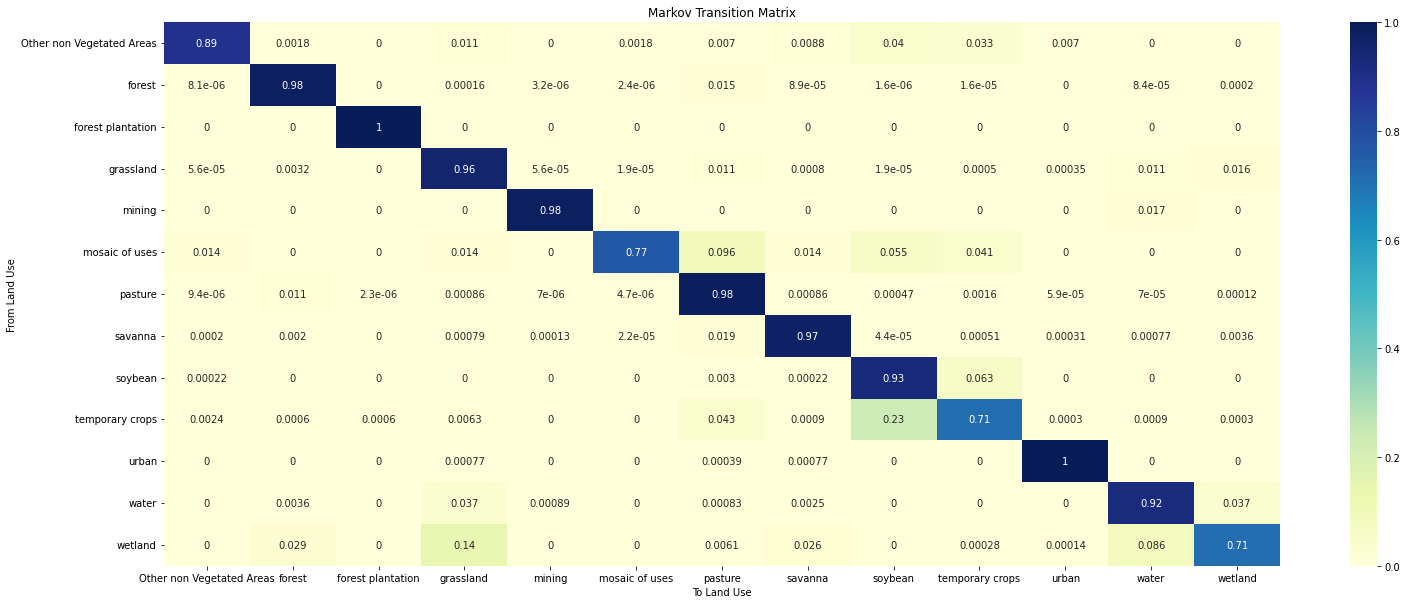

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(25, 10))

# plot the transition matrix as a heatmap
sns.heatmap(transition_matrix_df, annot=True, cmap="YlGnBu", xticklabels=transition_matrix_df.columns, yticklabels=transition_matrix_df.columns)

# add labels and title
plt.xlabel("To Land Use")
plt.ylabel("From Land Use")
plt.title("Markov Transition Matrix")

# show the plot
plt.show()


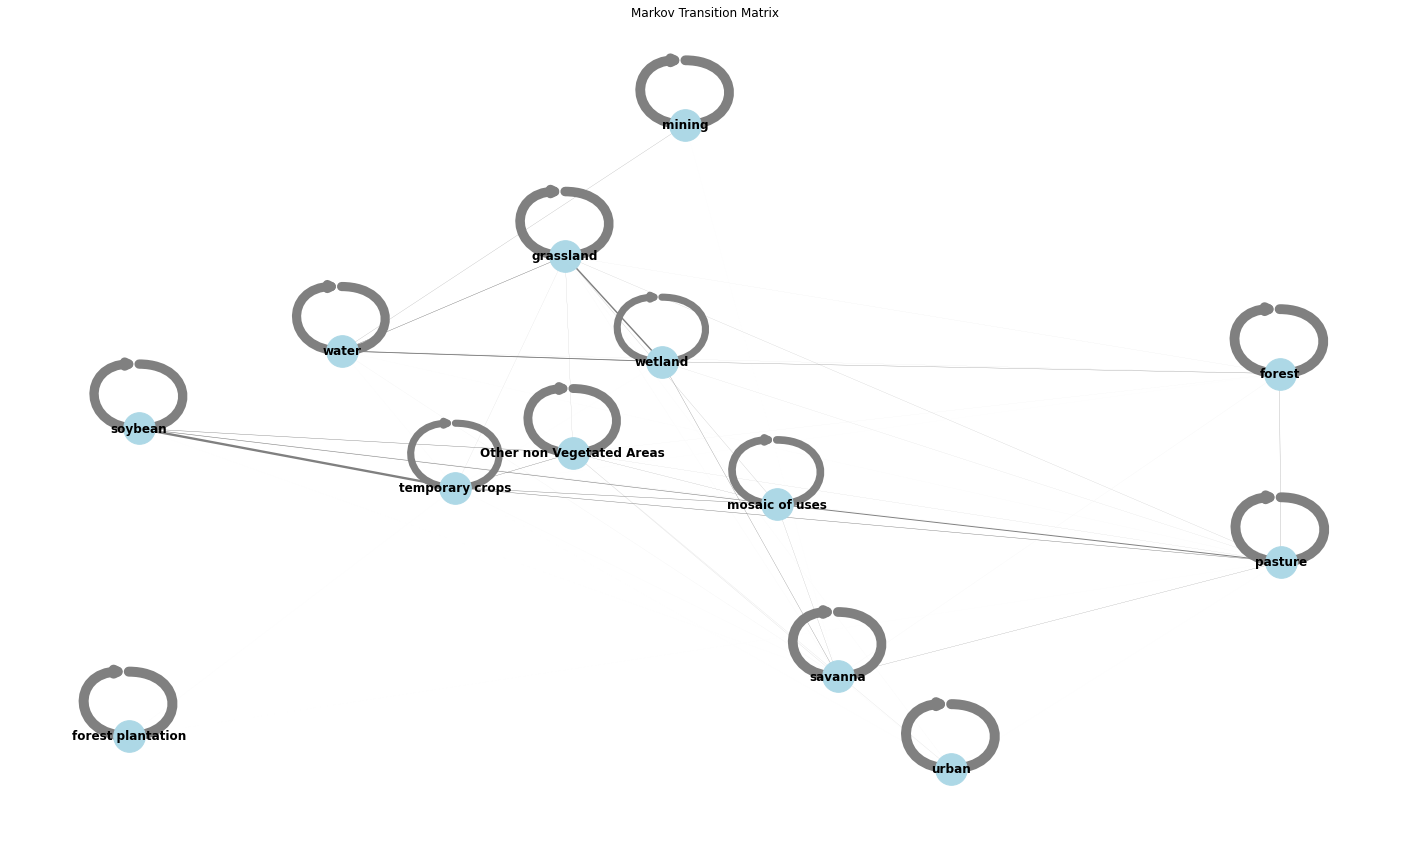

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# create a directed graph
G = nx.DiGraph()

# add nodes for each land use category
for category in transition_matrix_df.columns:
    G.add_node(category)

# add edges for each transition probability
for i, row in enumerate(transition_matrix):
    for j, probability in enumerate(row):
        if probability > 0:
            G.add_edge(transition_matrix_df.columns[i], transition_matrix_df.columns[j], weight=probability)

# set the figure size
fig, ax = plt.subplots(figsize=(25, 15))

# draw the graph
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue', ax=ax)
nx.draw_networkx_edges(G, pos, width=[10*G[u][v]['weight'] for u, v in G.edges()], edge_color='gray', ax=ax)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax)

# add labels and title
plt.xlabel("To Land Use")
plt.ylabel("From Land Use")
plt.title("Markov Transition Matrix")

# show the plot
plt.axis('off')
plt.show()


In [ ]:

# define the current land use category
current_category = 'forest'

# get the index of the current category
current_index = np.where(transition_matrix_df.columns == current_category)[0][0]

# use the transition matrix to estimate the probabilities of transitioning to each possible future land use category
future_probabilities = transition_matrix[current_index, :]

# print the estimated probabilities for each future land use category
for i, category in enumerate(transition_matrix_df.columns):
    print(f"Probability of transitioning to {category}: {future_probabilities[i]:.2f}")


Probability of transitioning to Other non Vegetated Areas: 0.00
Probability of transitioning to forest: 0.98
Probability of transitioning to forest plantation: 0.00
Probability of transitioning to grassland: 0.00
Probability of transitioning to mining: 0.00
Probability of transitioning to mosaic of uses: 0.00
Probability of transitioning to pasture: 0.02
Probability of transitioning to savanna: 0.00
Probability of transitioning to soybean: 0.00
Probability of transitioning to temporary crops: 0.00
Probability of transitioning to urban: 0.00
Probability of transitioning to water: 0.00
Probability of transitioning to wetland: 0.00
